In [1]:
# !pip install -U sentence-transformers -q

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [4]:
import os
import torchvision.transforms as tt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import numpy as np
import random
from PIL import Image
from sentence_transformers import SentenceTransformer

In [5]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
df = pd.read_csv('image_desc.csv')
df2 = df.groupby('Image Name')

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
image_transform = tt.Compose([ tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor(), tt.Normalize(*stats)])

In [7]:
class FlowerDescDataset(Dataset):
    def __init__(self, df2, transform = image_transform):
        self.desc_df = df2
        self.transform=transform
    
    def __len__(self):
        return self.desc_df.ngroups
    
    def __getitem__(self,index):
        img_name = list(self.desc_df.groups.keys())[index]
        img_path = 'jpg/flowers/' + img_name
        img = Image.open(img_path)
        # img = np.asarray(img)
        # img = torch.from_numpy(img)
        image=self.transform(img)

        descriptions = self.desc_df.get_group(img_name)
        matching_text = descriptions.iloc[random.randint(0, len(descriptions)-1), 2]

        random_row = df.sample(n=1)
        mismatching_text = random_row['Text Description'].values[0]
        while random_row['Image Name'].values[0] == img_name:
          random_row = df.sample(n=1)
          mismatching_text = random_row['Text Description'].values[0]
            
        return (image, matching_text, mismatching_text)

In [8]:
dataset = FlowerDescDataset(df2)
print(len(dataset))
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

8189


In [9]:
for image, matching_text, wrong_imagest in tqdm(dl):
  lst = list(matching_text)
  embeddings = sentence_model.encode(lst, device = device, convert_to_tensor = True)
  print(embeddings)
  print(embeddings.size())
  break

  0%|          | 0/128 [00:00<?, ?it/s]

tensor([[ 0.0460,  0.0165, -0.0573,  ...,  0.0639,  0.0724,  0.0384],
        [ 0.0255, -0.0429, -0.0069,  ...,  0.0226,  0.0680,  0.0029],
        [ 0.0270,  0.0672, -0.0599,  ...,  0.0881,  0.0358,  0.0837],
        ...,
        [ 0.0398,  0.0129, -0.0513,  ...,  0.0702,  0.0803,  0.0150],
        [ 0.0533,  0.0254, -0.0255,  ...,  0.0923,  0.0952,  0.0210],
        [-0.0336, -0.0940,  0.0026,  ...,  0.0754,  0.0532,  0.0360]],
       device='cuda:0')
torch.Size([64, 384])


# GENERATOR - DISCRIMINATOR

In [10]:
latent_size = 256
embedding_size = 384

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_size, embedding_size):
        super(Generator, self).__init__()

        # self.embeddings = text_embeddings(input)

        self.main = nn.Sequential(
            
            # latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size + embedding_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 8 x 8
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 16 x 16
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=4, padding=2, bias=False),
            nn.Tanh(),
            # 3 x 64 x 64
        )

    def forward(self, noise, text):
        concat = torch.cat((noise, text), dim = 1)
        concat = concat.unsqueeze(2).unsqueeze(3)
        return self.main(concat)

generator = Generator(latent_size, embedding_size).to(device)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.final = nn.Sequential(
            # 128 + 64 x 16 x 16
            nn.Conv2d(128 + 64, 32, kernel_size=8, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 x 4 x 4
            nn.Conv2d(32, 1, kernel_size=8, stride=4, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Sigmoid(),
        )

        self.img_down = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16
        )
        
        self.text_up = nn.Sequential(
            # 384 x 1 x 1
            nn.ConvTranspose2d(embedding_size, 128, kernel_size=8, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            nn.ConvTranspose2d(128, 64, kernel_size=8, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
        )

    def forward(self, image, text):
        image = self.img_down(image)
        text = text.unsqueeze(2).unsqueeze(3)
        text = self.text_up(text)
        concat = torch.cat((image, text), dim = 1)
        ret = self.final(concat)
        return ret

discriminator = Discriminator().to(device)

In [13]:
try:
    generator.load_state_dict(torch.load('CGAN_64_generator.pth'))
    generator.to(device)
    print("Loaded Generator Successfully")
except:
    print("No saved generator state found")

try:
    discriminator.load_state_dict(torch.load('CGAN_64_discriminator.pth'))
    discriminator.to(device)
    print("Loaded Discriminator Successfully")
except:
    print("No saved discriminator state found")

Loaded Generator Successfully
Loaded Discriminator Successfully


#TRAINING

In [14]:
def train_discriminator(opt_d, images, matching_encodings, mismatching_encodings):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # REAL IMAGE + RIGHT TEXT
    real_images = images.to(device)
    real_preds = discriminator(real_images, matching_encodings)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    sr = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(images.size(dim = 0), latent_size, device=device)
    fake_images = generator(latent, matching_encodings)

    #REAL IMAGE + WRONG TEXT
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(real_images, mismatching_encodings)
    sw = F.binary_cross_entropy(fake_preds, fake_targets)
    temp_score = torch.mean(fake_preds).item()

    # FAKE IMAGE + RIGHT TEXT
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images, matching_encodings)
    sf = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = sr + (sw + sf)/2
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, temp_score, fake_score

In [15]:
def train_generator(opt_g, matching_encodings, size):
    # Clear generator gradients
    opt_g.zero_grad()
    true_labels = torch.ones(batch_size).to(device)
    
    # Generate fake images
    latent = torch.randn(size, latent_size, device=device)
    fake_images = generator(latent, matching_encodings)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images, matching_encodings)
    targets = torch.ones(size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [16]:
def image(desc):  
  latent = torch.randn(1, latent_size, device=device)
  text = []
  text.append(desc)
  encoding = sentence_model.encode(text, device = device, convert_to_tensor = True)
  fake_images = generator(latent, encoding)
  fake_images = fake_images[0]
  fake_images = torch.squeeze(fake_images)
  fake_images = (fake_images + 1)/2
    
  fig = plt.figure(figsize=(4, 4))
  plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy(), interpolation = None)
  plt.show()

In [17]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    temp_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        loss_d_lst = []
        loss_g_lst = []
        real_score_lst = []
        fake_score_lst = []
        temp_score_lst = []
        for images, matching_text, mismatching_text in tqdm(dl):
            lst1 = list(matching_text)
            matching_encodings = sentence_model.encode(lst1, device = device, convert_to_tensor = True)
            lst2 = list(mismatching_text)
            mismatching_encodings = sentence_model.encode(lst2, device = device, convert_to_tensor = True)

            # Train discriminator
            loss_d, real_score, temp_score, fake_score = train_discriminator(opt_d, images, matching_encodings, mismatching_encodings)
            loss_d_lst.append(loss_d)
            real_score_lst.append(real_score)
            fake_score_lst.append(fake_score)
            temp_score_lst.append(temp_score)

            # Train generator
            loss_g = train_generator(opt_g, matching_encodings, images.size(dim = 0))
            loss_g_lst.append(loss_g)
            
        # Record losses & scores
        loss_g = statistics.mean(loss_g_lst)
        loss_d = statistics.mean(loss_d_lst)
        real_score = statistics.mean(real_score_lst)
        fake_score = statistics.mean(fake_score_lst)
        temp_score = statistics.mean(temp_score_lst)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        temp_scores.append(temp_score)
        
        # Log losses & scores (last batch)
        image("white-pinkish petals")
        print("Epoch [{}/{}], loss_g: {:.5f}, loss_d: {:.5f}, real_score: {:.5f}, temp_score: {:.5f}, fake_score: {:.5f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, temp_score, fake_score))
    
        # # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)

        #Show Samples
        # latent = torch.randn(1, latent_size, 1, 1, device=device)
        # fake_images = generator(latent)
        # print(fake_images.size())
        # fake_images = torch.squeeze(fake_images)
        # print(fake_images.size())
        # plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy())
        # plt.show()
    
    return losses_g, losses_d, real_scores, temp_scores, fake_scores

  0%|          | 0/128 [00:00<?, ?it/s]

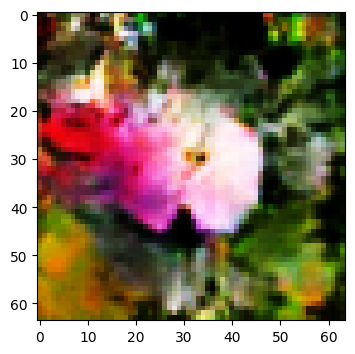

Epoch [1/128], loss_g: 2.29974, loss_d: 0.25074, real_score: 0.94099, temp_score: 0.11608, fake_score: 0.15257


  0%|          | 0/128 [00:00<?, ?it/s]

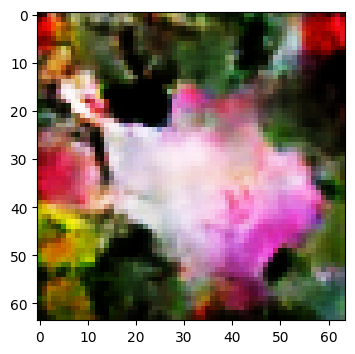

Epoch [2/128], loss_g: 2.33313, loss_d: 0.17789, real_score: 0.96553, temp_score: 0.10702, fake_score: 0.13458


  0%|          | 0/128 [00:00<?, ?it/s]

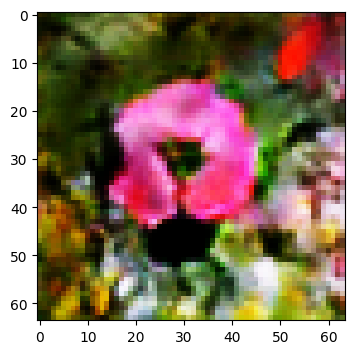

Epoch [3/128], loss_g: 2.45690, loss_d: 0.24742, real_score: 0.94072, temp_score: 0.11671, fake_score: 0.14454


  0%|          | 0/128 [00:00<?, ?it/s]

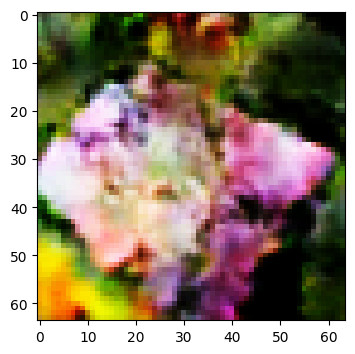

Epoch [4/128], loss_g: 2.40740, loss_d: 0.17881, real_score: 0.96345, temp_score: 0.10355, fake_score: 0.12998


  0%|          | 0/128 [00:00<?, ?it/s]

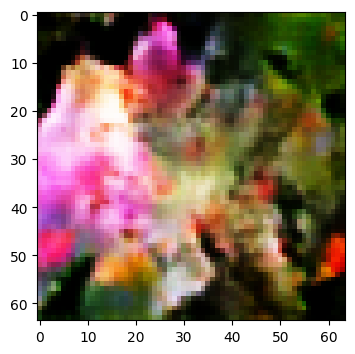

Epoch [5/128], loss_g: 2.40752, loss_d: 0.19957, real_score: 0.95568, temp_score: 0.10603, fake_score: 0.13314


  0%|          | 0/128 [00:00<?, ?it/s]

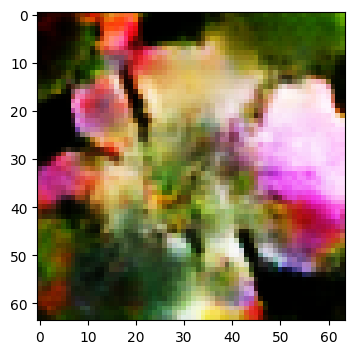

Epoch [6/128], loss_g: 2.39900, loss_d: 0.17435, real_score: 0.96435, temp_score: 0.10115, fake_score: 0.12919


  0%|          | 0/128 [00:00<?, ?it/s]

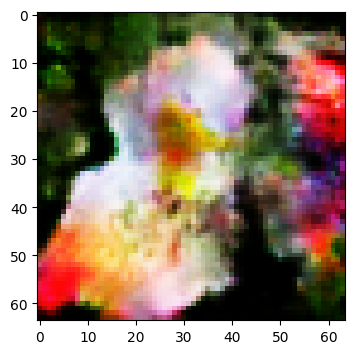

Epoch [7/128], loss_g: 2.43938, loss_d: 0.34805, real_score: 0.91385, temp_score: 0.11013, fake_score: 0.14877


  0%|          | 0/128 [00:00<?, ?it/s]

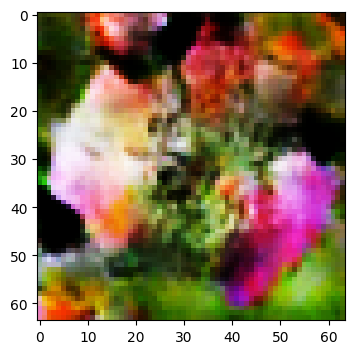

Epoch [8/128], loss_g: 2.32397, loss_d: 0.19708, real_score: 0.95834, temp_score: 0.10776, fake_score: 0.14467


  0%|          | 0/128 [00:00<?, ?it/s]

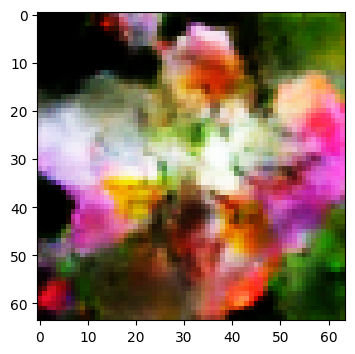

Epoch [9/128], loss_g: 2.42563, loss_d: 0.16891, real_score: 0.96664, temp_score: 0.09522, fake_score: 0.12770


  0%|          | 0/128 [00:00<?, ?it/s]

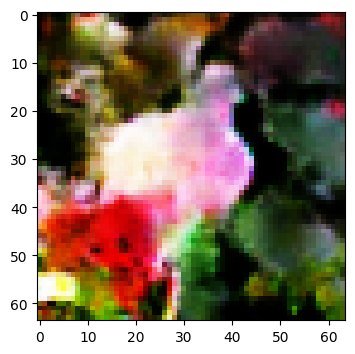

Epoch [10/128], loss_g: 2.48185, loss_d: 0.20213, real_score: 0.95347, temp_score: 0.10475, fake_score: 0.12854


  0%|          | 0/128 [00:00<?, ?it/s]

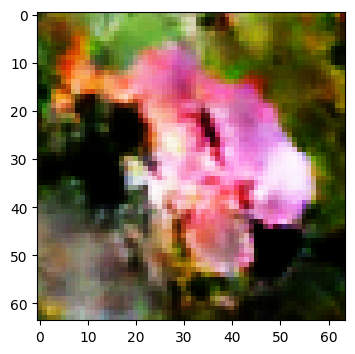

Epoch [11/128], loss_g: 2.42918, loss_d: 0.18107, real_score: 0.96210, temp_score: 0.09874, fake_score: 0.12927


  0%|          | 0/128 [00:00<?, ?it/s]

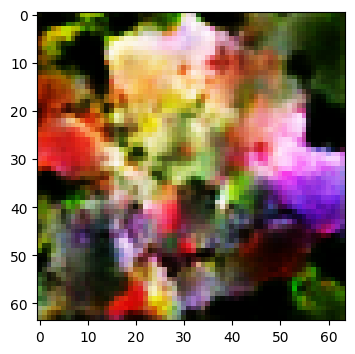

Epoch [12/128], loss_g: 2.05181, loss_d: 0.49431, real_score: 0.86168, temp_score: 0.12780, fake_score: 0.22275


  0%|          | 0/128 [00:00<?, ?it/s]

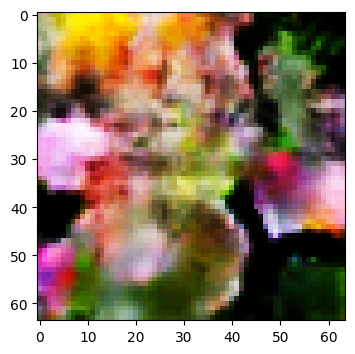

Epoch [13/128], loss_g: 2.31864, loss_d: 0.19104, real_score: 0.95929, temp_score: 0.10149, fake_score: 0.14180


  0%|          | 0/128 [00:00<?, ?it/s]

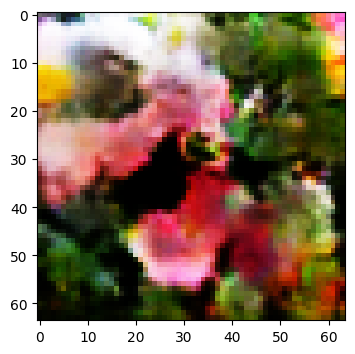

Epoch [14/128], loss_g: 2.31319, loss_d: 0.22437, real_score: 0.94889, temp_score: 0.10245, fake_score: 0.14744


  0%|          | 0/128 [00:00<?, ?it/s]

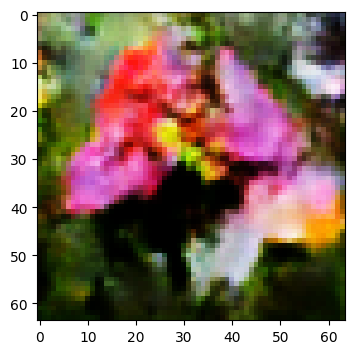

Epoch [15/128], loss_g: 2.45532, loss_d: 0.18827, real_score: 0.95978, temp_score: 0.09820, fake_score: 0.13106


  0%|          | 0/128 [00:00<?, ?it/s]

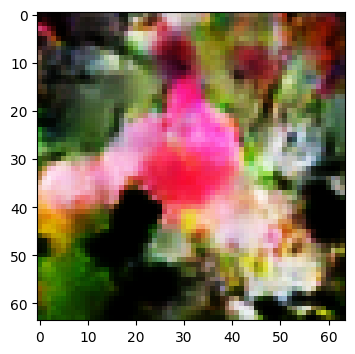

Epoch [16/128], loss_g: 2.47834, loss_d: 0.15898, real_score: 0.96761, temp_score: 0.09149, fake_score: 0.11855


  0%|          | 0/128 [00:00<?, ?it/s]

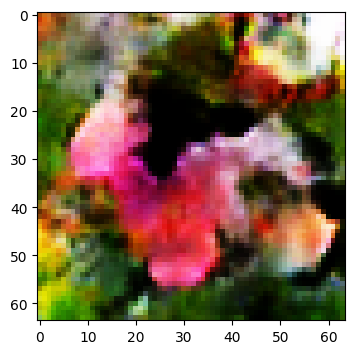

Epoch [17/128], loss_g: 2.47574, loss_d: 0.17410, real_score: 0.96226, temp_score: 0.09623, fake_score: 0.12419


  0%|          | 0/128 [00:00<?, ?it/s]

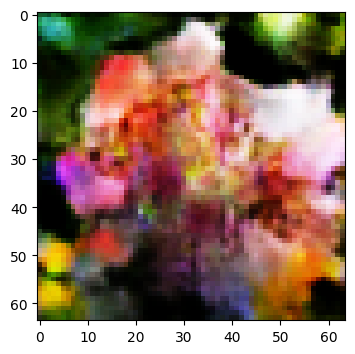

Epoch [18/128], loss_g: 2.52569, loss_d: 0.15389, real_score: 0.96819, temp_score: 0.08371, fake_score: 0.11673


  0%|          | 0/128 [00:00<?, ?it/s]

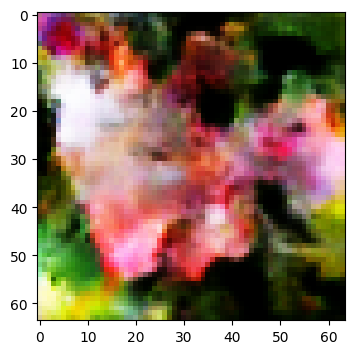

Epoch [19/128], loss_g: 2.55683, loss_d: 0.20617, real_score: 0.95124, temp_score: 0.10239, fake_score: 0.12756


  0%|          | 0/128 [00:00<?, ?it/s]

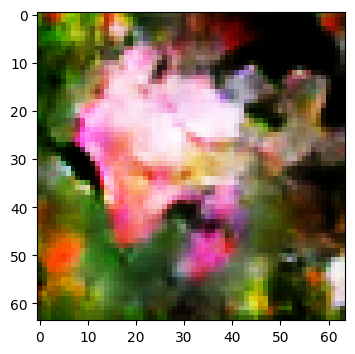

Epoch [20/128], loss_g: 2.31003, loss_d: 0.42022, real_score: 0.89239, temp_score: 0.11540, fake_score: 0.17943


  0%|          | 0/128 [00:00<?, ?it/s]

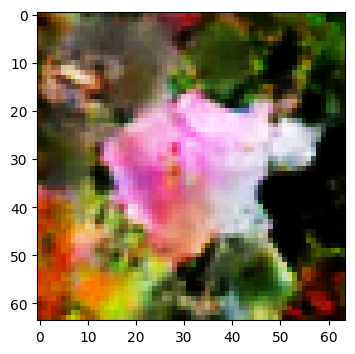

Epoch [21/128], loss_g: 2.42664, loss_d: 0.19019, real_score: 0.95758, temp_score: 0.09502, fake_score: 0.13486


  0%|          | 0/128 [00:00<?, ?it/s]

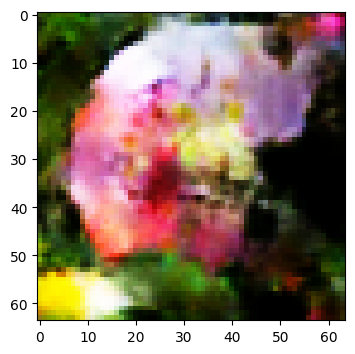

Epoch [22/128], loss_g: 2.49783, loss_d: 0.17149, real_score: 0.96346, temp_score: 0.09266, fake_score: 0.12285


  0%|          | 0/128 [00:00<?, ?it/s]

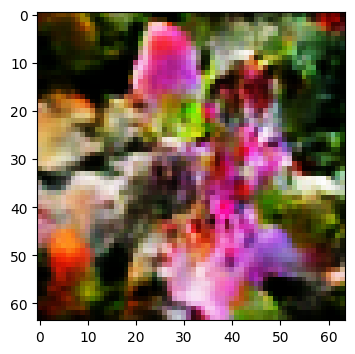

Epoch [23/128], loss_g: 2.54356, loss_d: 0.16177, real_score: 0.96705, temp_score: 0.09070, fake_score: 0.11935


  0%|          | 0/128 [00:00<?, ?it/s]

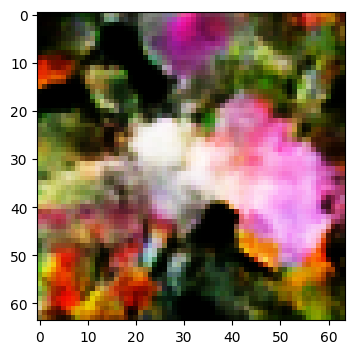

Epoch [24/128], loss_g: 2.42536, loss_d: 0.22985, real_score: 0.94312, temp_score: 0.09690, fake_score: 0.14106


  0%|          | 0/128 [00:00<?, ?it/s]

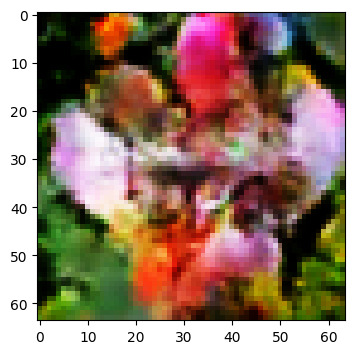

Epoch [25/128], loss_g: 2.53263, loss_d: 0.15502, real_score: 0.96974, temp_score: 0.09175, fake_score: 0.11736


  0%|          | 0/128 [00:00<?, ?it/s]

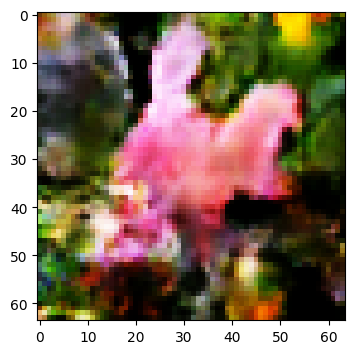

Epoch [26/128], loss_g: 2.56567, loss_d: 0.19538, real_score: 0.95498, temp_score: 0.09671, fake_score: 0.12584


  0%|          | 0/128 [00:00<?, ?it/s]

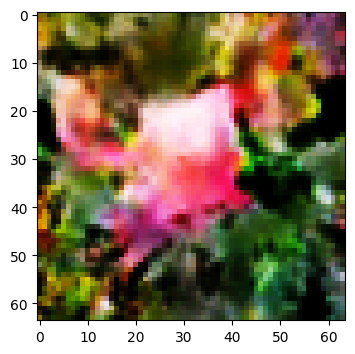

Epoch [27/128], loss_g: 2.53296, loss_d: 0.29537, real_score: 0.92368, temp_score: 0.09836, fake_score: 0.14662


  0%|          | 0/128 [00:00<?, ?it/s]

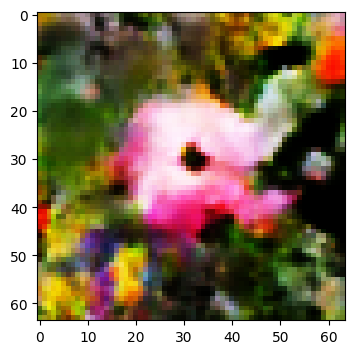

Epoch [28/128], loss_g: 2.46895, loss_d: 0.17061, real_score: 0.96237, temp_score: 0.08835, fake_score: 0.12220


  0%|          | 0/128 [00:00<?, ?it/s]

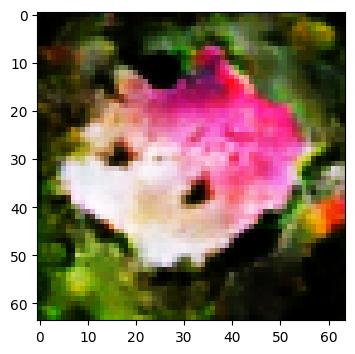

Epoch [29/128], loss_g: 2.50015, loss_d: 0.28356, real_score: 0.92917, temp_score: 0.09710, fake_score: 0.13970


  0%|          | 0/128 [00:00<?, ?it/s]

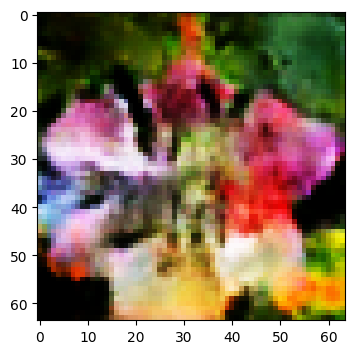

Epoch [30/128], loss_g: 2.53025, loss_d: 0.16819, real_score: 0.96398, temp_score: 0.08816, fake_score: 0.12419


  0%|          | 0/128 [00:00<?, ?it/s]

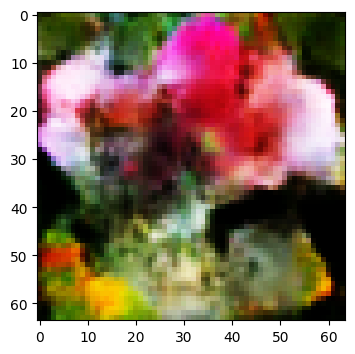

Epoch [31/128], loss_g: 2.58316, loss_d: 0.17529, real_score: 0.96095, temp_score: 0.09031, fake_score: 0.11844


  0%|          | 0/128 [00:00<?, ?it/s]

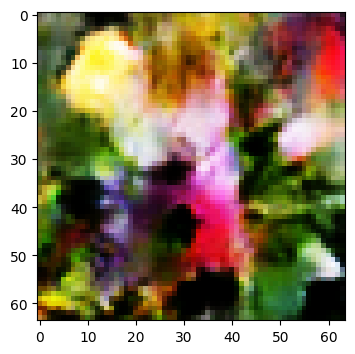

Epoch [32/128], loss_g: 2.51767, loss_d: 0.16766, real_score: 0.96276, temp_score: 0.08440, fake_score: 0.11963


  0%|          | 0/128 [00:00<?, ?it/s]

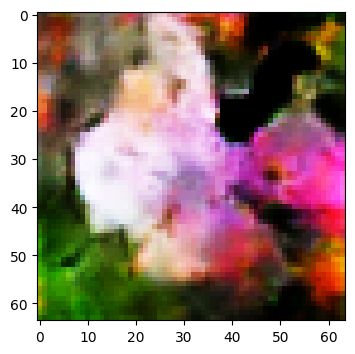

Epoch [33/128], loss_g: 2.53144, loss_d: 0.15299, real_score: 0.96755, temp_score: 0.08276, fake_score: 0.11457


  0%|          | 0/128 [00:00<?, ?it/s]

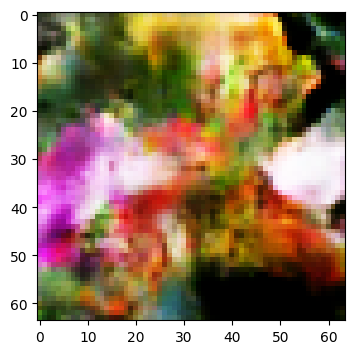

Epoch [34/128], loss_g: 2.65030, loss_d: 0.26865, real_score: 0.94611, temp_score: 0.08902, fake_score: 0.12577


  0%|          | 0/128 [00:00<?, ?it/s]

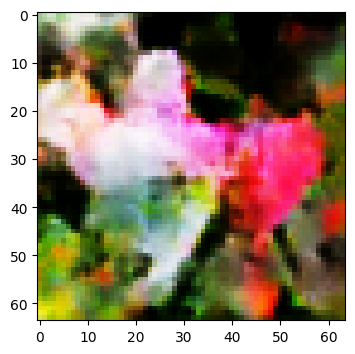

Epoch [35/128], loss_g: 2.22531, loss_d: 0.40382, real_score: 0.89980, temp_score: 0.10594, fake_score: 0.17820


  0%|          | 0/128 [00:00<?, ?it/s]

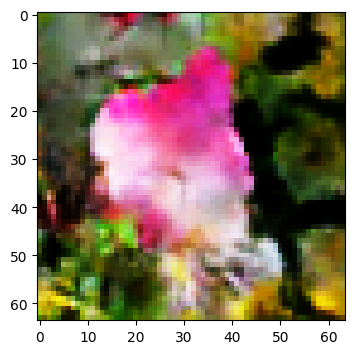

Epoch [36/128], loss_g: 2.42306, loss_d: 0.16281, real_score: 0.96615, temp_score: 0.08513, fake_score: 0.12661


  0%|          | 0/128 [00:00<?, ?it/s]

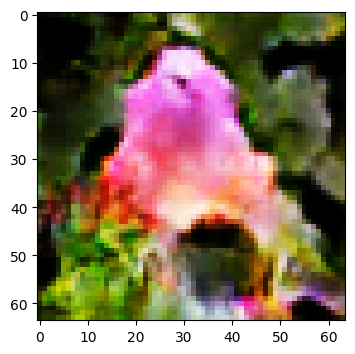

Epoch [37/128], loss_g: 2.52030, loss_d: 0.17187, real_score: 0.96122, temp_score: 0.08284, fake_score: 0.12316


  0%|          | 0/128 [00:00<?, ?it/s]

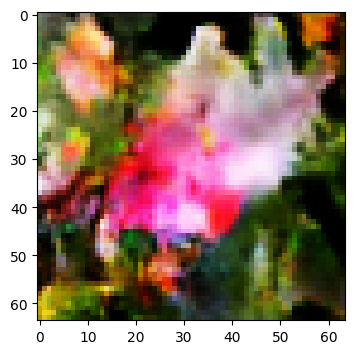

Epoch [38/128], loss_g: 2.55052, loss_d: 0.14319, real_score: 0.97155, temp_score: 0.07992, fake_score: 0.11323


  0%|          | 0/128 [00:00<?, ?it/s]

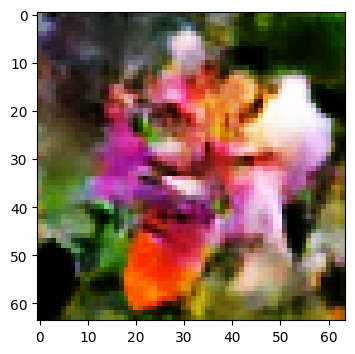

Epoch [39/128], loss_g: 2.51863, loss_d: 0.24479, real_score: 0.94036, temp_score: 0.09045, fake_score: 0.13281


  0%|          | 0/128 [00:00<?, ?it/s]

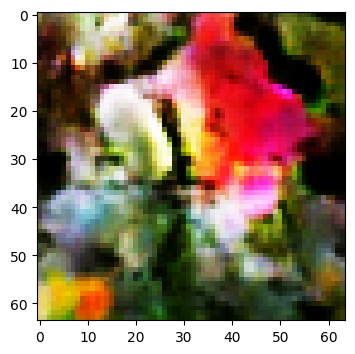

Epoch [40/128], loss_g: 2.51519, loss_d: 0.26567, real_score: 0.94097, temp_score: 0.09377, fake_score: 0.13789


  0%|          | 0/128 [00:00<?, ?it/s]

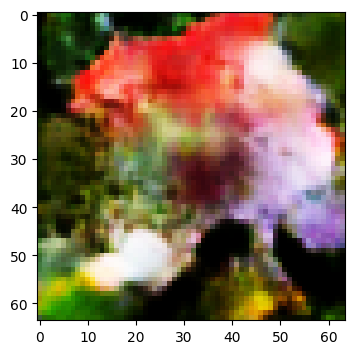

Epoch [41/128], loss_g: 2.53135, loss_d: 0.14676, real_score: 0.96986, temp_score: 0.07640, fake_score: 0.11619


  0%|          | 0/128 [00:00<?, ?it/s]

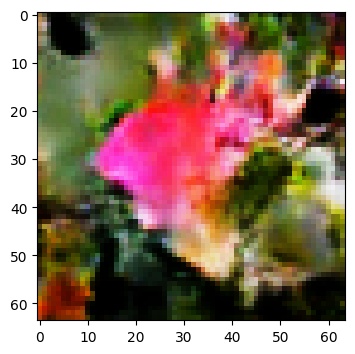

Epoch [42/128], loss_g: 2.57781, loss_d: 0.13600, real_score: 0.97133, temp_score: 0.07245, fake_score: 0.10787


  0%|          | 0/128 [00:00<?, ?it/s]

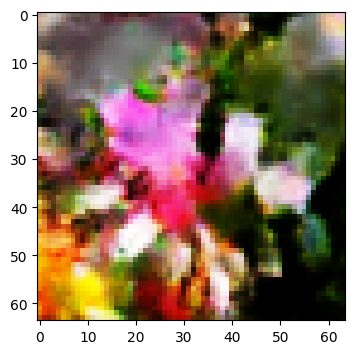

Epoch [43/128], loss_g: 2.60871, loss_d: 0.16520, real_score: 0.96387, temp_score: 0.08370, fake_score: 0.11814


  0%|          | 0/128 [00:00<?, ?it/s]

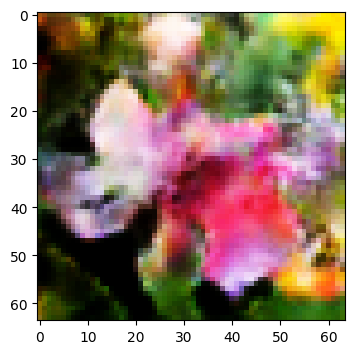

Epoch [44/128], loss_g: 2.62129, loss_d: 0.14232, real_score: 0.97010, temp_score: 0.07499, fake_score: 0.10803


  0%|          | 0/128 [00:00<?, ?it/s]

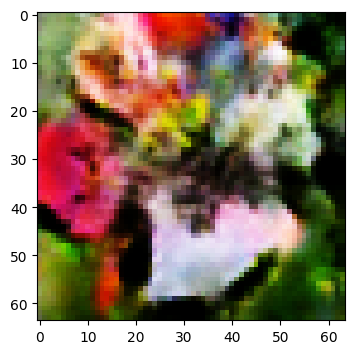

Epoch [45/128], loss_g: 2.55665, loss_d: 0.28576, real_score: 0.92852, temp_score: 0.08631, fake_score: 0.13396


  0%|          | 0/128 [00:00<?, ?it/s]

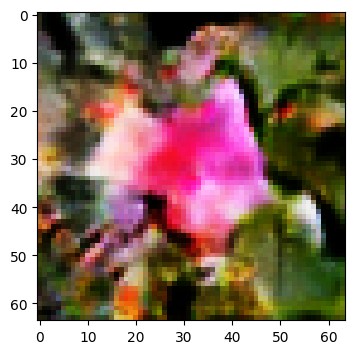

Epoch [46/128], loss_g: 2.56749, loss_d: 0.16094, real_score: 0.96467, temp_score: 0.07503, fake_score: 0.11764


  0%|          | 0/128 [00:00<?, ?it/s]

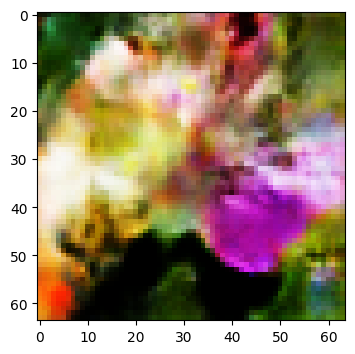

Epoch [47/128], loss_g: 2.53427, loss_d: 0.16695, real_score: 0.96319, temp_score: 0.08057, fake_score: 0.12463


  0%|          | 0/128 [00:00<?, ?it/s]

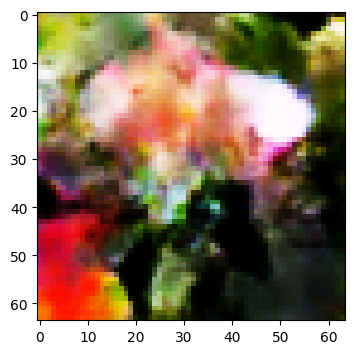

Epoch [48/128], loss_g: 2.61372, loss_d: 0.14048, real_score: 0.97182, temp_score: 0.07616, fake_score: 0.11044


  0%|          | 0/128 [00:00<?, ?it/s]

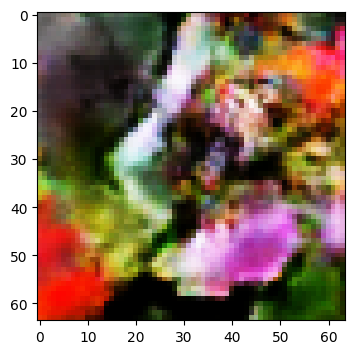

Epoch [49/128], loss_g: 2.60603, loss_d: 0.14336, real_score: 0.97009, temp_score: 0.07219, fake_score: 0.11097


  0%|          | 0/128 [00:00<?, ?it/s]

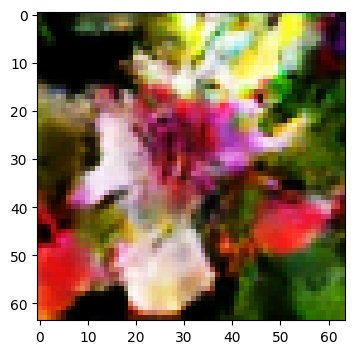

Epoch [50/128], loss_g: 2.67504, loss_d: 0.13788, real_score: 0.97112, temp_score: 0.06997, fake_score: 0.10872


  0%|          | 0/128 [00:00<?, ?it/s]

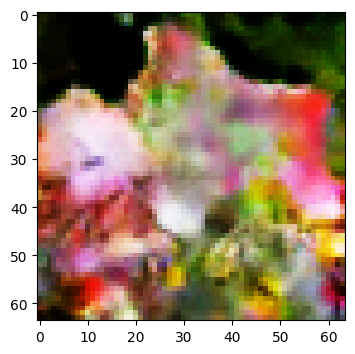

Epoch [51/128], loss_g: 2.71160, loss_d: 0.22287, real_score: 0.94705, temp_score: 0.07915, fake_score: 0.11454


  0%|          | 0/128 [00:00<?, ?it/s]

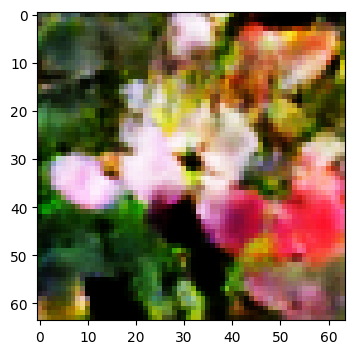

Epoch [52/128], loss_g: 2.50279, loss_d: 0.23998, real_score: 0.93860, temp_score: 0.08945, fake_score: 0.14352


  0%|          | 0/128 [00:00<?, ?it/s]

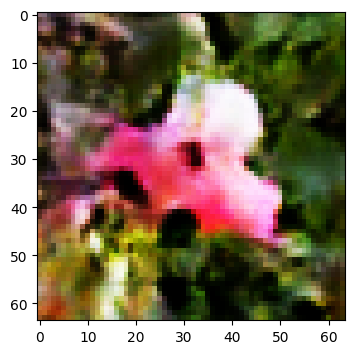

Epoch [53/128], loss_g: 2.45701, loss_d: 0.32992, real_score: 0.91426, temp_score: 0.09832, fake_score: 0.16059


  0%|          | 0/128 [00:00<?, ?it/s]

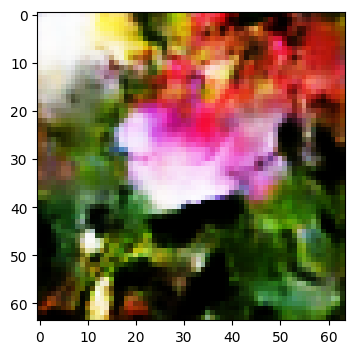

Epoch [54/128], loss_g: 2.48595, loss_d: 0.17155, real_score: 0.96176, temp_score: 0.07912, fake_score: 0.12767


  0%|          | 0/128 [00:00<?, ?it/s]

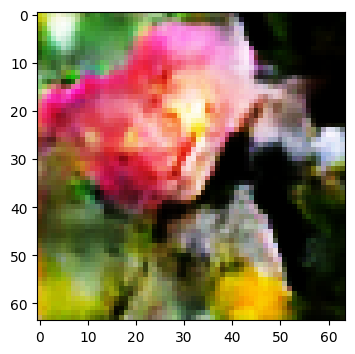

Epoch [55/128], loss_g: 2.58244, loss_d: 0.14073, real_score: 0.97067, temp_score: 0.07107, fake_score: 0.11265


  0%|          | 0/128 [00:00<?, ?it/s]

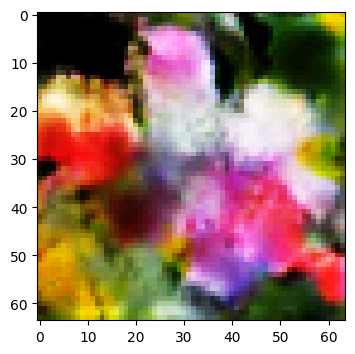

Epoch [56/128], loss_g: 2.65629, loss_d: 0.25906, real_score: 0.93547, temp_score: 0.08562, fake_score: 0.13142


  0%|          | 0/128 [00:00<?, ?it/s]

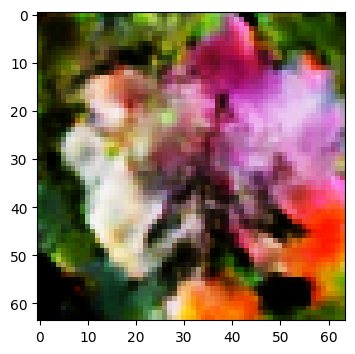

Epoch [57/128], loss_g: 2.58366, loss_d: 0.17385, real_score: 0.95999, temp_score: 0.08112, fake_score: 0.12050


  0%|          | 0/128 [00:00<?, ?it/s]

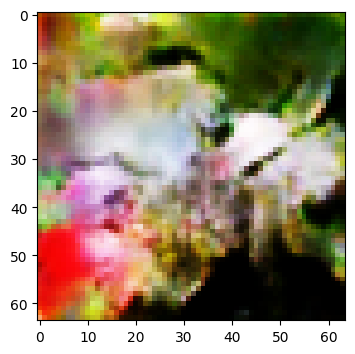

Epoch [58/128], loss_g: 2.58993, loss_d: 0.14346, real_score: 0.96894, temp_score: 0.06956, fake_score: 0.11408


  0%|          | 0/128 [00:00<?, ?it/s]

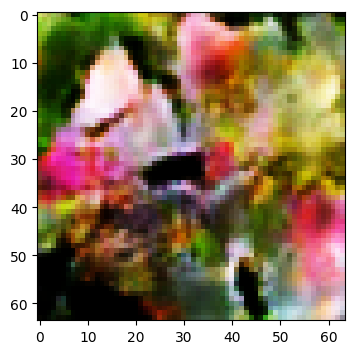

Epoch [59/128], loss_g: 2.65951, loss_d: 0.15447, real_score: 0.96481, temp_score: 0.07605, fake_score: 0.11167


  0%|          | 0/128 [00:00<?, ?it/s]

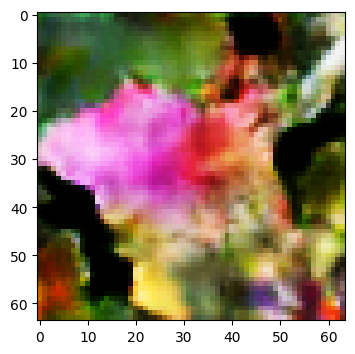

Epoch [60/128], loss_g: 2.63399, loss_d: 0.16439, real_score: 0.96084, temp_score: 0.07620, fake_score: 0.11267


  0%|          | 0/128 [00:00<?, ?it/s]

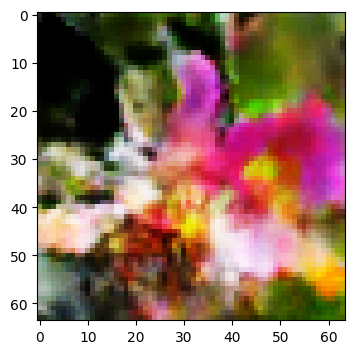

Epoch [61/128], loss_g: 2.66263, loss_d: 0.17481, real_score: 0.95781, temp_score: 0.07704, fake_score: 0.11051


  0%|          | 0/128 [00:00<?, ?it/s]

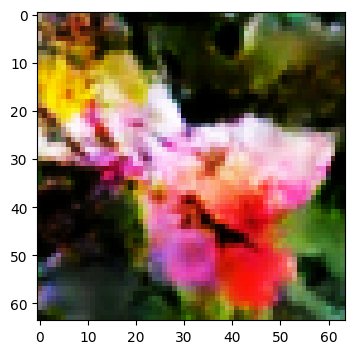

Epoch [62/128], loss_g: 2.71630, loss_d: 0.18903, real_score: 0.95449, temp_score: 0.07266, fake_score: 0.11349


  0%|          | 0/128 [00:00<?, ?it/s]

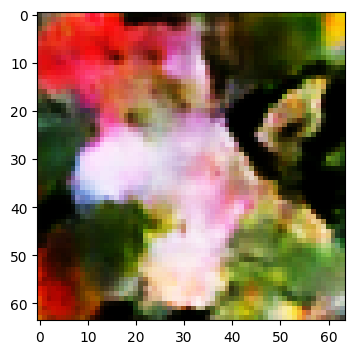

Epoch [63/128], loss_g: 2.62799, loss_d: 0.13629, real_score: 0.97142, temp_score: 0.06491, fake_score: 0.11081


  0%|          | 0/128 [00:00<?, ?it/s]

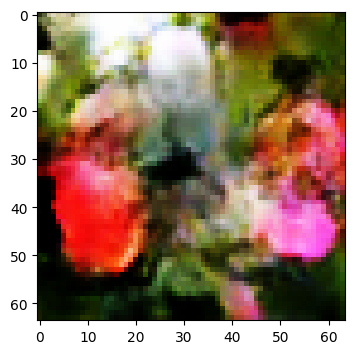

Epoch [64/128], loss_g: 2.67290, loss_d: 0.13091, real_score: 0.97263, temp_score: 0.06778, fake_score: 0.10441


  0%|          | 0/128 [00:00<?, ?it/s]

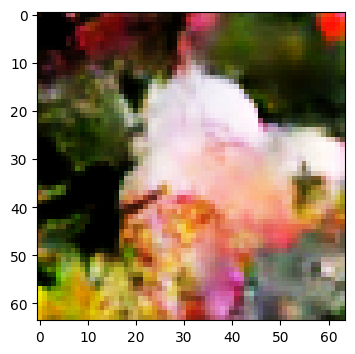

Epoch [65/128], loss_g: 2.63499, loss_d: 0.13794, real_score: 0.97131, temp_score: 0.07291, fake_score: 0.10798


  0%|          | 0/128 [00:00<?, ?it/s]

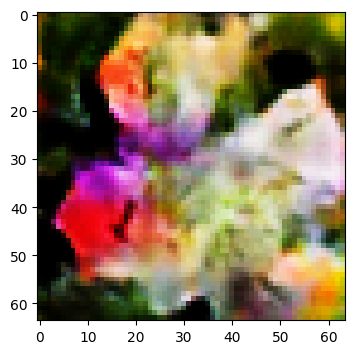

Epoch [66/128], loss_g: 2.33512, loss_d: 0.52883, real_score: 0.85603, temp_score: 0.10478, fake_score: 0.21404


  0%|          | 0/128 [00:00<?, ?it/s]

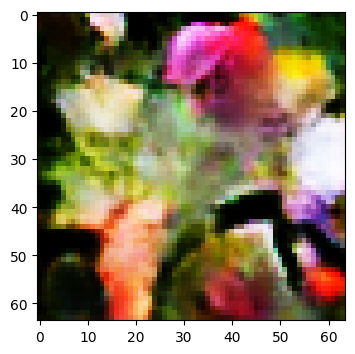

Epoch [67/128], loss_g: 2.45533, loss_d: 0.19844, real_score: 0.95336, temp_score: 0.08686, fake_score: 0.13699


  0%|          | 0/128 [00:00<?, ?it/s]

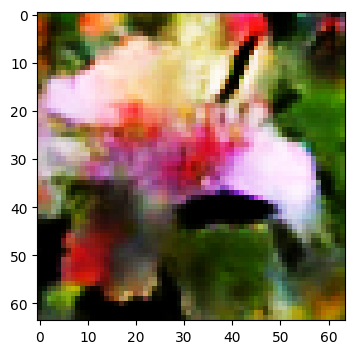

Epoch [68/128], loss_g: 2.60851, loss_d: 0.16285, real_score: 0.96178, temp_score: 0.07333, fake_score: 0.11660


  0%|          | 0/128 [00:00<?, ?it/s]

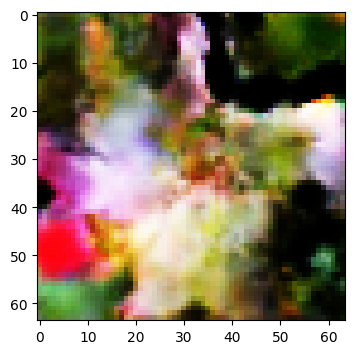

Epoch [69/128], loss_g: 2.58644, loss_d: 0.15204, real_score: 0.96678, temp_score: 0.07668, fake_score: 0.11534


  0%|          | 0/128 [00:00<?, ?it/s]

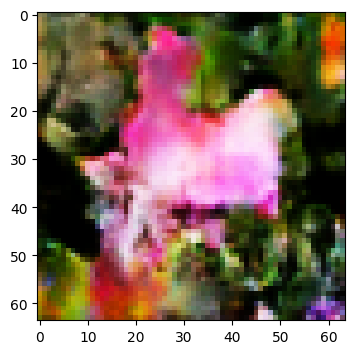

Epoch [70/128], loss_g: 2.62510, loss_d: 0.12806, real_score: 0.97368, temp_score: 0.06533, fake_score: 0.10483


  0%|          | 0/128 [00:00<?, ?it/s]

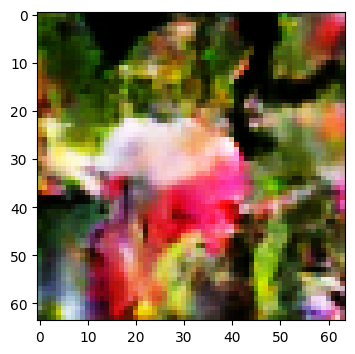

Epoch [71/128], loss_g: 2.61114, loss_d: 0.13246, real_score: 0.97288, temp_score: 0.06779, fake_score: 0.10582


  0%|          | 0/128 [00:00<?, ?it/s]

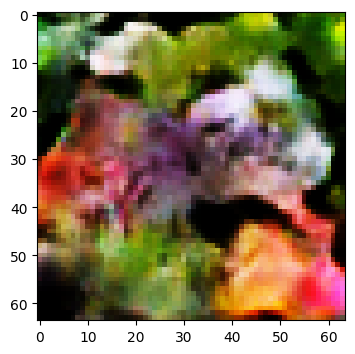

Epoch [72/128], loss_g: 2.70509, loss_d: 0.14033, real_score: 0.96916, temp_score: 0.06818, fake_score: 0.10678


  0%|          | 0/128 [00:00<?, ?it/s]

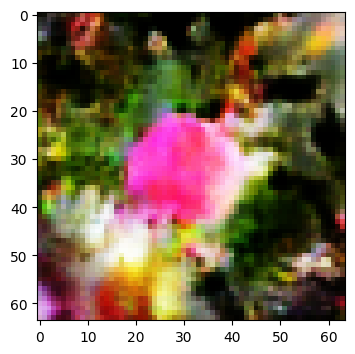

Epoch [73/128], loss_g: 2.62600, loss_d: 0.27125, real_score: 0.93563, temp_score: 0.07937, fake_score: 0.13238


  0%|          | 0/128 [00:00<?, ?it/s]

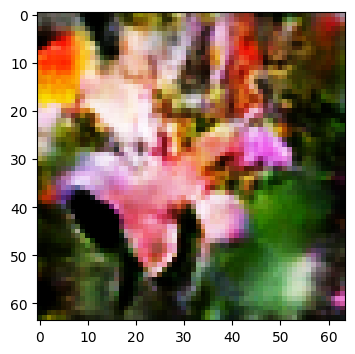

Epoch [74/128], loss_g: 2.56555, loss_d: 0.13816, real_score: 0.97074, temp_score: 0.06474, fake_score: 0.11487


  0%|          | 0/128 [00:00<?, ?it/s]

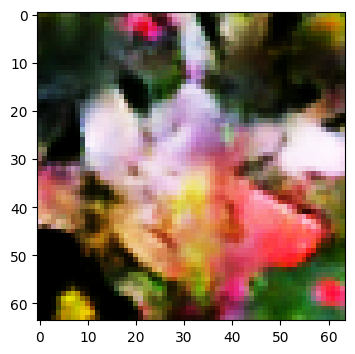

Epoch [75/128], loss_g: 2.69164, loss_d: 0.15095, real_score: 0.96737, temp_score: 0.07494, fake_score: 0.11076


  0%|          | 0/128 [00:00<?, ?it/s]

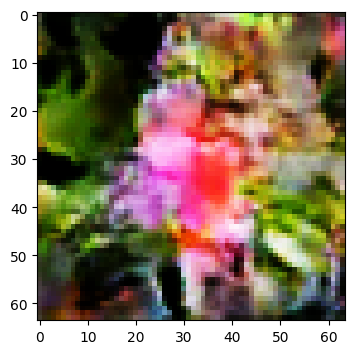

Epoch [76/128], loss_g: 2.68888, loss_d: 0.12949, real_score: 0.97183, temp_score: 0.06329, fake_score: 0.10191


  0%|          | 0/128 [00:00<?, ?it/s]

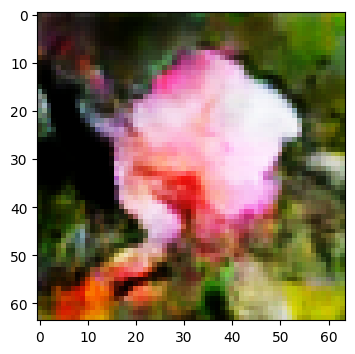

Epoch [77/128], loss_g: 2.66267, loss_d: 0.13945, real_score: 0.97017, temp_score: 0.06643, fake_score: 0.11091


  0%|          | 0/128 [00:00<?, ?it/s]

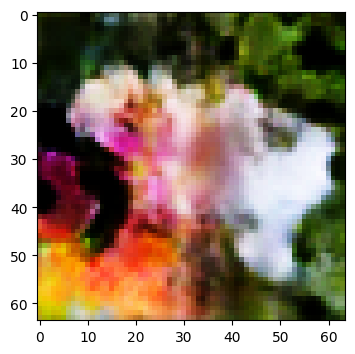

Epoch [78/128], loss_g: 2.33737, loss_d: 0.48242, real_score: 0.87601, temp_score: 0.09930, fake_score: 0.18814


  0%|          | 0/128 [00:00<?, ?it/s]

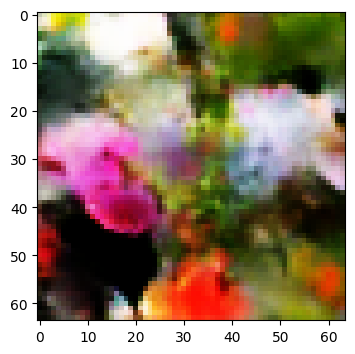

Epoch [79/128], loss_g: 2.52808, loss_d: 0.22267, real_score: 0.94303, temp_score: 0.07833, fake_score: 0.13964


  0%|          | 0/128 [00:00<?, ?it/s]

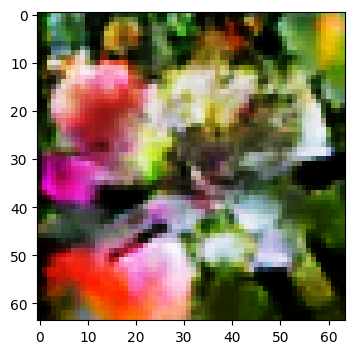

Epoch [80/128], loss_g: 2.61046, loss_d: 0.14168, real_score: 0.97039, temp_score: 0.07272, fake_score: 0.11175


  0%|          | 0/128 [00:00<?, ?it/s]

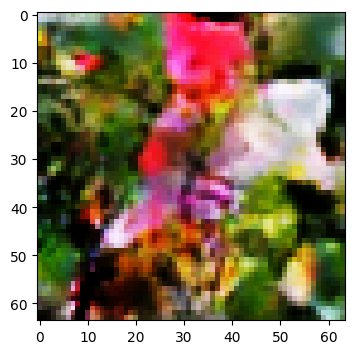

Epoch [81/128], loss_g: 2.71164, loss_d: 0.12755, real_score: 0.97349, temp_score: 0.06019, fake_score: 0.10594


  0%|          | 0/128 [00:00<?, ?it/s]

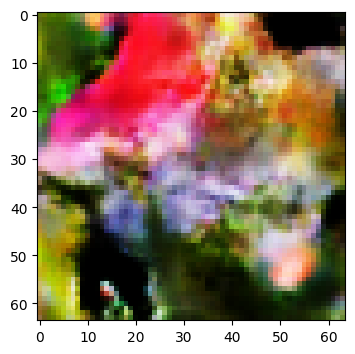

Epoch [82/128], loss_g: 2.69099, loss_d: 0.13787, real_score: 0.96882, temp_score: 0.06621, fake_score: 0.10510


  0%|          | 0/128 [00:00<?, ?it/s]

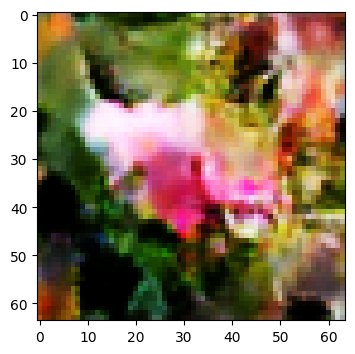

Epoch [83/128], loss_g: 2.70166, loss_d: 0.13082, real_score: 0.97167, temp_score: 0.06297, fake_score: 0.10279


  0%|          | 0/128 [00:00<?, ?it/s]

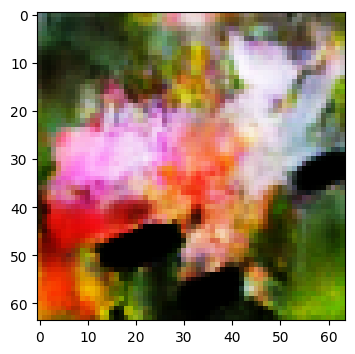

Epoch [84/128], loss_g: 2.68396, loss_d: 0.11970, real_score: 0.97505, temp_score: 0.05639, fake_score: 0.10360


  0%|          | 0/128 [00:00<?, ?it/s]

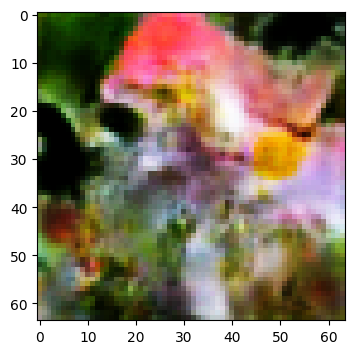

Epoch [85/128], loss_g: 2.72631, loss_d: 0.14013, real_score: 0.96884, temp_score: 0.06655, fake_score: 0.10432


  0%|          | 0/128 [00:00<?, ?it/s]

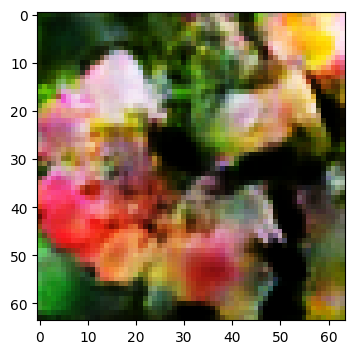

Epoch [86/128], loss_g: 2.74806, loss_d: 0.32238, real_score: 0.91864, temp_score: 0.07162, fake_score: 0.13146


  0%|          | 0/128 [00:00<?, ?it/s]

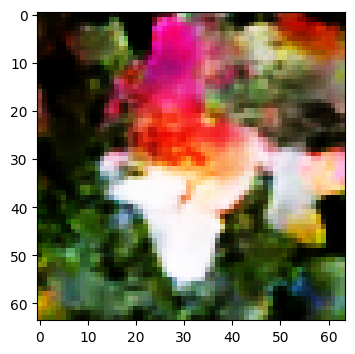

Epoch [87/128], loss_g: 2.60985, loss_d: 0.15820, real_score: 0.96293, temp_score: 0.06921, fake_score: 0.11769


  0%|          | 0/128 [00:00<?, ?it/s]

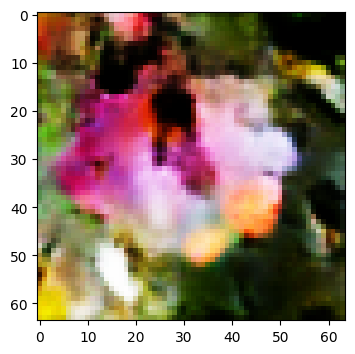

Epoch [88/128], loss_g: 2.70761, loss_d: 0.14802, real_score: 0.96511, temp_score: 0.06434, fake_score: 0.10954


  0%|          | 0/128 [00:00<?, ?it/s]

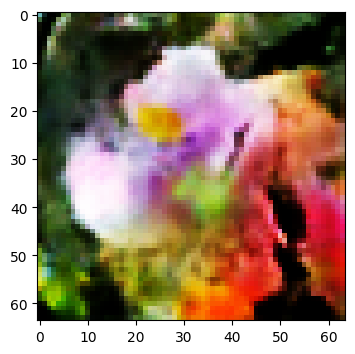

Epoch [89/128], loss_g: 2.70453, loss_d: 0.13427, real_score: 0.97105, temp_score: 0.06263, fake_score: 0.10637


  0%|          | 0/128 [00:00<?, ?it/s]

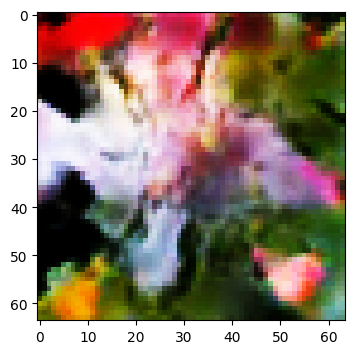

Epoch [90/128], loss_g: 2.75651, loss_d: 0.20091, real_score: 0.95123, temp_score: 0.06475, fake_score: 0.11519


  0%|          | 0/128 [00:00<?, ?it/s]

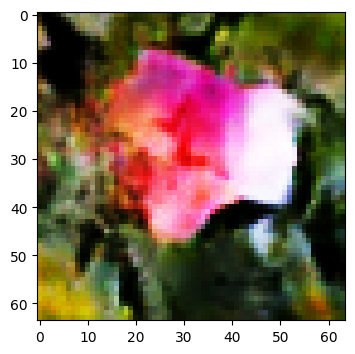

Epoch [91/128], loss_g: 2.72591, loss_d: 0.14120, real_score: 0.96783, temp_score: 0.06498, fake_score: 0.10440


  0%|          | 0/128 [00:00<?, ?it/s]

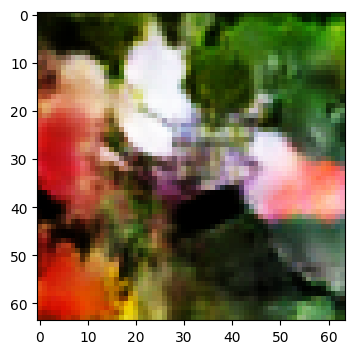

Epoch [92/128], loss_g: 2.75959, loss_d: 0.15321, real_score: 0.96457, temp_score: 0.05917, fake_score: 0.10434


  0%|          | 0/128 [00:00<?, ?it/s]

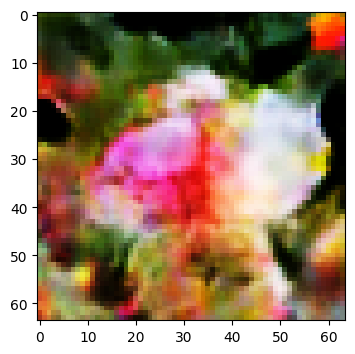

Epoch [93/128], loss_g: 2.78467, loss_d: 0.13156, real_score: 0.96773, temp_score: 0.05499, fake_score: 0.09823


  0%|          | 0/128 [00:00<?, ?it/s]

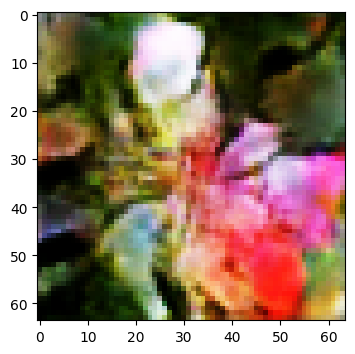

Epoch [94/128], loss_g: 2.76034, loss_d: 0.13527, real_score: 0.97126, temp_score: 0.05767, fake_score: 0.10381


  0%|          | 0/128 [00:00<?, ?it/s]

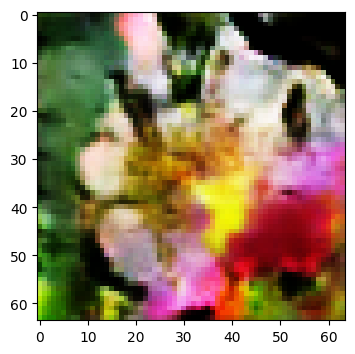

Epoch [95/128], loss_g: 2.77837, loss_d: 0.15555, real_score: 0.96391, temp_score: 0.06595, fake_score: 0.11315


  0%|          | 0/128 [00:00<?, ?it/s]

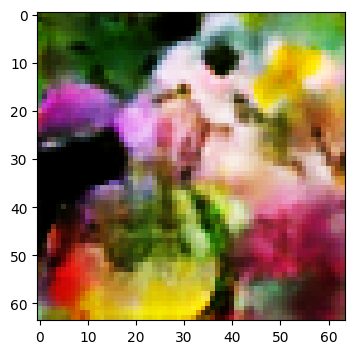

Epoch [96/128], loss_g: 2.82921, loss_d: 0.11987, real_score: 0.97422, temp_score: 0.05623, fake_score: 0.09876


  0%|          | 0/128 [00:00<?, ?it/s]

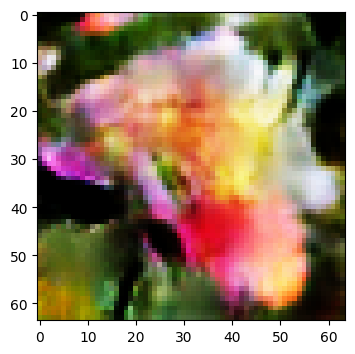

Epoch [97/128], loss_g: 2.73827, loss_d: 0.32977, real_score: 0.91059, temp_score: 0.07672, fake_score: 0.13924


  0%|          | 0/128 [00:00<?, ?it/s]

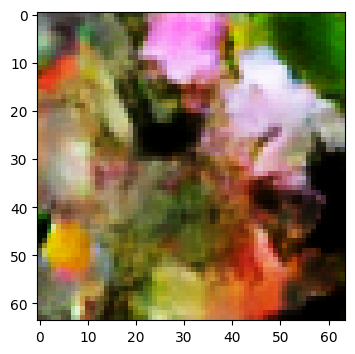

Epoch [98/128], loss_g: 2.66129, loss_d: 0.12046, real_score: 0.97577, temp_score: 0.05834, fake_score: 0.10412


  0%|          | 0/128 [00:00<?, ?it/s]

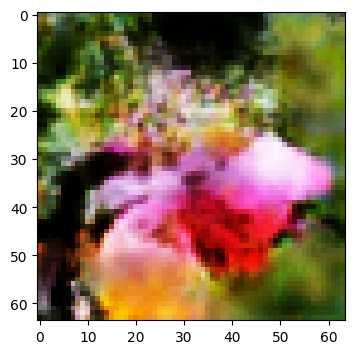

Epoch [99/128], loss_g: 2.78121, loss_d: 0.13713, real_score: 0.96902, temp_score: 0.06391, fake_score: 0.10203


  0%|          | 0/128 [00:00<?, ?it/s]

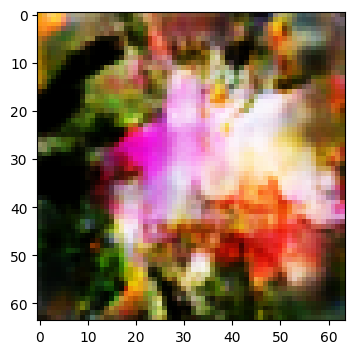

Epoch [100/128], loss_g: 2.73897, loss_d: 0.22755, real_score: 0.94198, temp_score: 0.06610, fake_score: 0.12640


  0%|          | 0/128 [00:00<?, ?it/s]

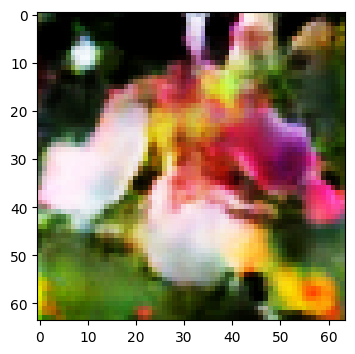

Epoch [101/128], loss_g: 2.81012, loss_d: 0.14827, real_score: 0.96444, temp_score: 0.06476, fake_score: 0.10623


  0%|          | 0/128 [00:00<?, ?it/s]

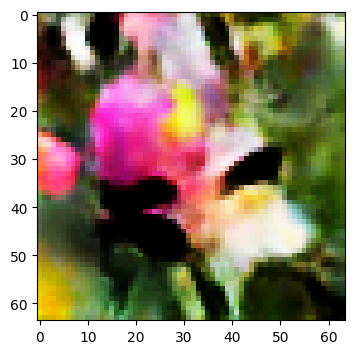

Epoch [102/128], loss_g: 2.79811, loss_d: 0.11350, real_score: 0.97687, temp_score: 0.05356, fake_score: 0.09688


  0%|          | 0/128 [00:00<?, ?it/s]

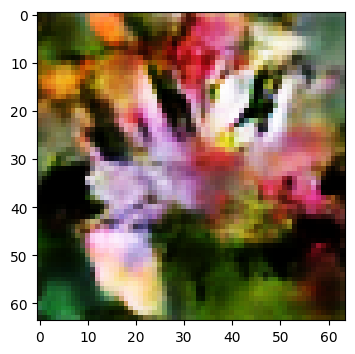

Epoch [103/128], loss_g: 2.79919, loss_d: 0.12207, real_score: 0.97294, temp_score: 0.05538, fake_score: 0.09689


  0%|          | 0/128 [00:00<?, ?it/s]

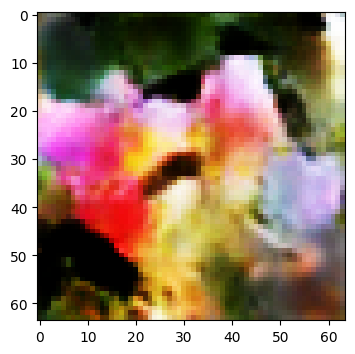

Epoch [104/128], loss_g: 2.66416, loss_d: 0.31660, real_score: 0.92216, temp_score: 0.07266, fake_score: 0.14101


  0%|          | 0/128 [00:00<?, ?it/s]

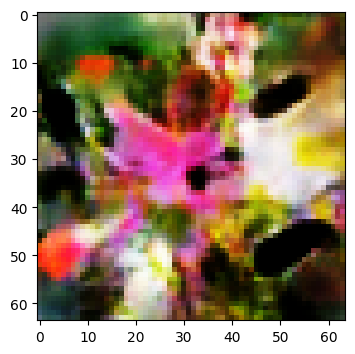

Epoch [105/128], loss_g: 2.70185, loss_d: 0.13560, real_score: 0.97031, temp_score: 0.05911, fake_score: 0.10959


  0%|          | 0/128 [00:00<?, ?it/s]

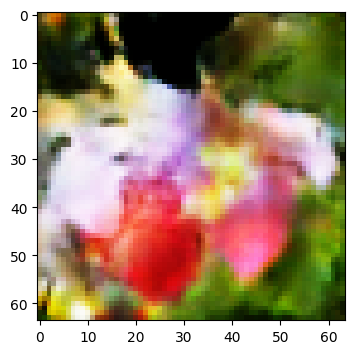

Epoch [106/128], loss_g: 2.71924, loss_d: 0.16074, real_score: 0.96271, temp_score: 0.06338, fake_score: 0.11286


  0%|          | 0/128 [00:00<?, ?it/s]

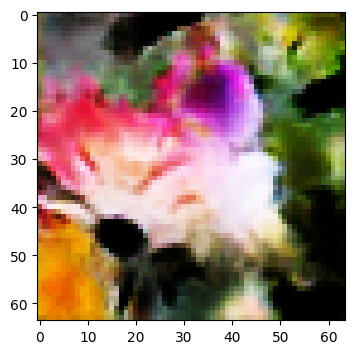

Epoch [107/128], loss_g: 2.73517, loss_d: 0.12304, real_score: 0.97345, temp_score: 0.05647, fake_score: 0.10109


  0%|          | 0/128 [00:00<?, ?it/s]

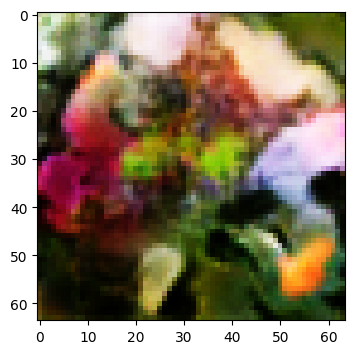

Epoch [108/128], loss_g: 2.73688, loss_d: 0.13006, real_score: 0.96992, temp_score: 0.05613, fake_score: 0.10076


  0%|          | 0/128 [00:00<?, ?it/s]

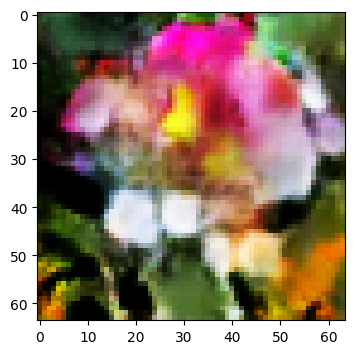

Epoch [109/128], loss_g: 2.86098, loss_d: 0.15913, real_score: 0.95988, temp_score: 0.05911, fake_score: 0.10633


  0%|          | 0/128 [00:00<?, ?it/s]

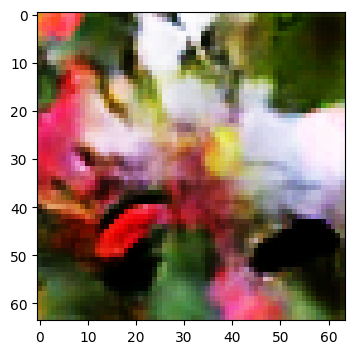

Epoch [110/128], loss_g: 2.77375, loss_d: 0.15645, real_score: 0.96189, temp_score: 0.06465, fake_score: 0.10782


  0%|          | 0/128 [00:00<?, ?it/s]

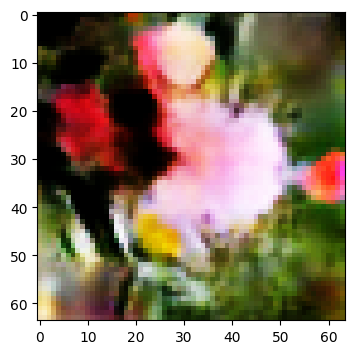

Epoch [111/128], loss_g: 2.80571, loss_d: 0.13175, real_score: 0.96911, temp_score: 0.05762, fake_score: 0.09931


  0%|          | 0/128 [00:00<?, ?it/s]

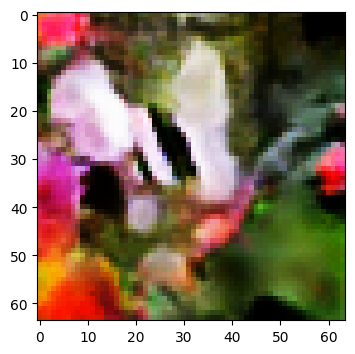

Epoch [112/128], loss_g: 2.80501, loss_d: 0.12910, real_score: 0.97038, temp_score: 0.05556, fake_score: 0.10090


  0%|          | 0/128 [00:00<?, ?it/s]

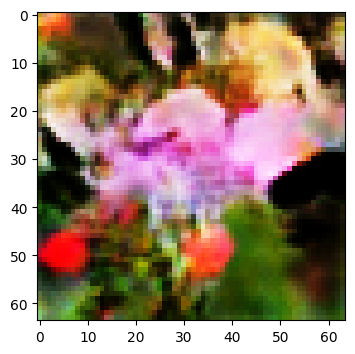

Epoch [113/128], loss_g: 2.79614, loss_d: 0.14462, real_score: 0.96587, temp_score: 0.05566, fake_score: 0.10449


  0%|          | 0/128 [00:00<?, ?it/s]

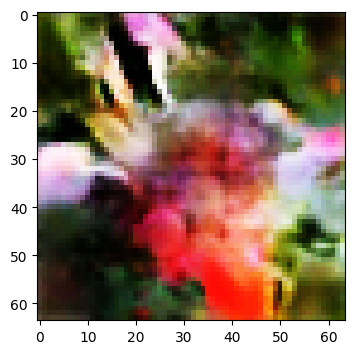

Epoch [114/128], loss_g: 2.85946, loss_d: 0.15578, real_score: 0.96248, temp_score: 0.05488, fake_score: 0.10570


  0%|          | 0/128 [00:00<?, ?it/s]

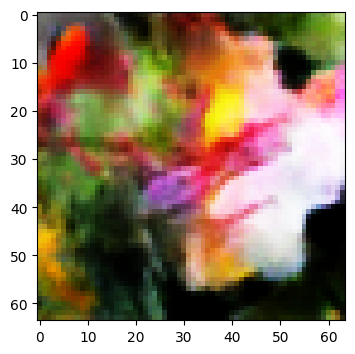

Epoch [115/128], loss_g: 2.92192, loss_d: 0.10537, real_score: 0.97796, temp_score: 0.05022, fake_score: 0.08915


  0%|          | 0/128 [00:00<?, ?it/s]

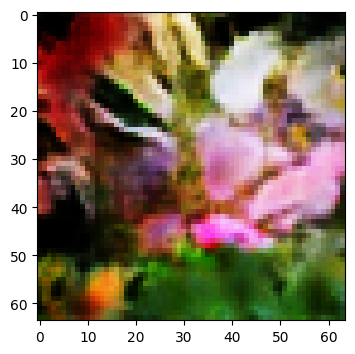

Epoch [116/128], loss_g: 2.84769, loss_d: 0.13333, real_score: 0.96878, temp_score: 0.05635, fake_score: 0.09866


  0%|          | 0/128 [00:00<?, ?it/s]

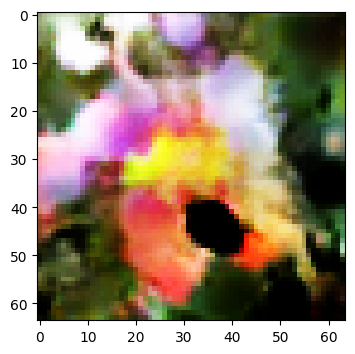

Epoch [117/128], loss_g: 2.89456, loss_d: 0.10906, real_score: 0.97647, temp_score: 0.04984, fake_score: 0.09100


  0%|          | 0/128 [00:00<?, ?it/s]

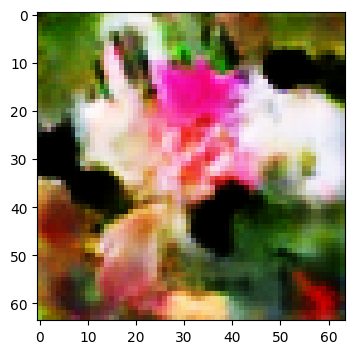

Epoch [118/128], loss_g: 2.76704, loss_d: 0.35121, real_score: 0.91439, temp_score: 0.06634, fake_score: 0.13755


  0%|          | 0/128 [00:00<?, ?it/s]

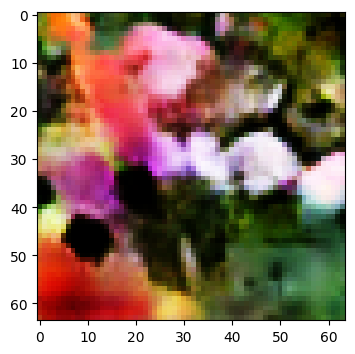

Epoch [119/128], loss_g: 2.74692, loss_d: 0.14760, real_score: 0.96434, temp_score: 0.05814, fake_score: 0.10895


  0%|          | 0/128 [00:00<?, ?it/s]

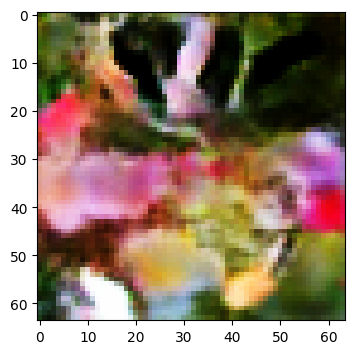

Epoch [120/128], loss_g: 2.81945, loss_d: 0.10900, real_score: 0.97749, temp_score: 0.05222, fake_score: 0.09319


  0%|          | 0/128 [00:00<?, ?it/s]

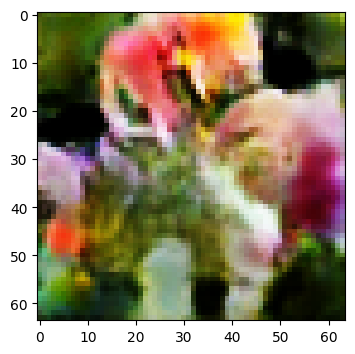

Epoch [121/128], loss_g: 2.73927, loss_d: 0.11976, real_score: 0.97349, temp_score: 0.05097, fake_score: 0.10043


  0%|          | 0/128 [00:00<?, ?it/s]

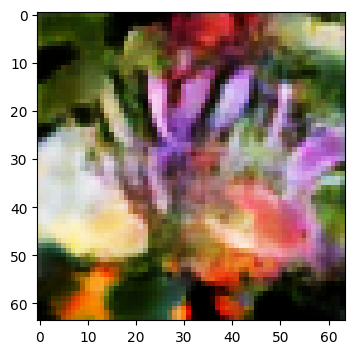

Epoch [122/128], loss_g: 2.74081, loss_d: 0.13336, real_score: 0.96932, temp_score: 0.05352, fake_score: 0.10553


  0%|          | 0/128 [00:00<?, ?it/s]

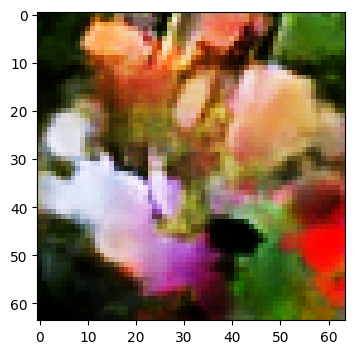

Epoch [123/128], loss_g: 2.78424, loss_d: 0.10811, real_score: 0.97654, temp_score: 0.04578, fake_score: 0.09464


  0%|          | 0/128 [00:00<?, ?it/s]

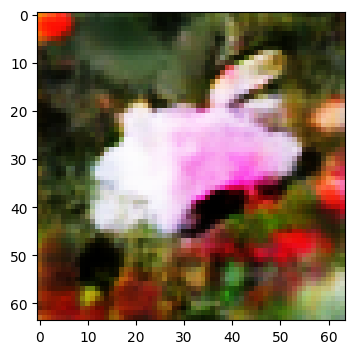

Epoch [124/128], loss_g: 2.81815, loss_d: 0.26883, real_score: 0.93718, temp_score: 0.05875, fake_score: 0.11642


  0%|          | 0/128 [00:00<?, ?it/s]

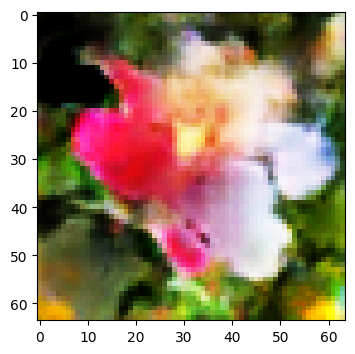

Epoch [125/128], loss_g: 2.68189, loss_d: 0.17750, real_score: 0.95342, temp_score: 0.06289, fake_score: 0.12279


  0%|          | 0/128 [00:00<?, ?it/s]

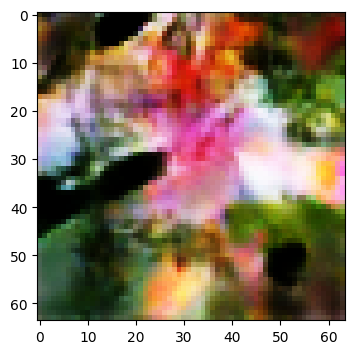

Epoch [126/128], loss_g: 2.74632, loss_d: 0.13084, real_score: 0.97120, temp_score: 0.05815, fake_score: 0.10516


  0%|          | 0/128 [00:00<?, ?it/s]

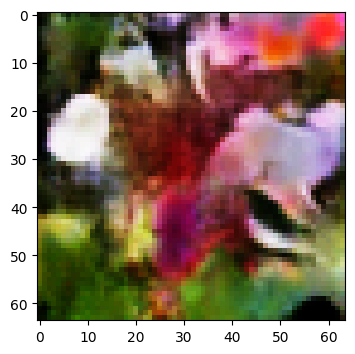

Epoch [127/128], loss_g: 2.83844, loss_d: 0.19300, real_score: 0.94843, temp_score: 0.06033, fake_score: 0.11532


  0%|          | 0/128 [00:00<?, ?it/s]

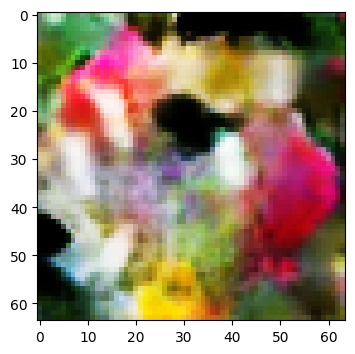

Epoch [128/128], loss_g: 2.87318, loss_d: 0.11182, real_score: 0.97526, temp_score: 0.04845, fake_score: 0.09390


In [18]:
epochs = 128
lr = 0.0002

history = fit(epochs, lr)

ENTER DESCRIPTION: purple-blue petals


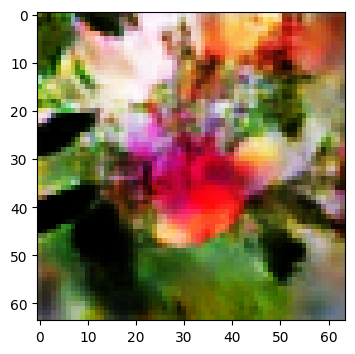

In [20]:
desc = input("ENTER DESCRIPTION: ")
image(desc)

# for i in range(int(input("NUMBER OF SAMPLES :"))):
#     image(desc)

In [19]:
torch.save(discriminator.state_dict(), 'CGAN_64_discriminator.pth')
torch.save(generator.state_dict(), 'CGAN_64_generator.pth')